In [11]:
model_dir = 'example_submission/'
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'
input_dir = 'public_data/'
output_dir = 'output/'
from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir);
path.append(input_dir); path.append(output_dir);
%matplotlib inline
# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
%load_ext autoreload
%autoreload 2
import seaborn as sns; sns.set()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [12]:
data_dir = 'public_data/hard'              # Change this to the directory where you put the input data
!ls $data_dir*

chronics  configuration.yaml  reference_grid.m


In [13]:
import os
import pypownet.environment
import pypownet.runner
data_dir = 'public_data'  
environment = pypownet.environment.RunEnv(parameters_folder=os.path.abspath(data_dir),
                                              game_level="hard",
                                              chronic_looping_mode='natural', start_id=0,
                                              game_over_mode="soft")

Using custom reward signal CustomRewardSignal of file /home/tp-home004/kratovo/MiniProj/Grid/starting_kit/public_data/reward_signal.py



                     GAME PARAMETERS
    max_number_loads_game_over: 6
    max_number_prods_game_over: 3
    n_timesteps_hard_overflow_is_broken: 10
    loadflow_backend: pypower
    n_timesteps_consecutive_soft_overflow_breaks: 10
    max_seconds_per_timestep: 1.0
    n_timesteps_horizon_maintenance: 48
    loadflow_mode: AC
    hard_overflow_coefficient: 1.0
    n_timesteps_soft_overflow_is_broken: 10



In [14]:
from scoring_program import libscores
from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)
# Uncomment the next line to display the code of the scoring metric
#??scoring_function

Using scoring metric: reward


In [15]:
import time
start = time.time()
end = time.time()
print(end-start)

4.935264587402344e-05


In [27]:
class CustomAgent(pypownet.agent.Agent):
    """
    An example of a baseline controler that randomly switches the status of one random power line per timestep (if the
    random line is previously online, switch it off, otherwise switch it on).
    """
    def __init__(self, environment):
        super().__init__(environment)
    
    def act(self, observation):
        """ Produces an action given an observation of the environment. Takes as argument an observation of the current
        power grid, and returns the chosen action."""
        # Sanity check: an observation is a structured object defined in the environment file.
        assert isinstance(observation, pypownet.environment.Observation)
        #print(" DO NOTHING AGENT !!! ")
        action_space = self.environment.action_space

        # Implement your policy here
        # Example of the do-nothing policy that produces no action (i.e. an action that does nothing) each time
        do_nothing_action = action_space.get_do_nothing_action()

        # Sanity check: verify the good overall structure of the returned action; raises exceptions if not valid
        assert action_space.verify_action_shape(do_nothing_action)
        return do_nothing_action

        # No learning (i.e. self.feed_reward does pass)

In [28]:
import logging
import sys
import time
start = time.time()
NUMBER_ITERATIONS = 1000

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))


open(log_path, 'w').close()
submitted_controler = CustomAgent(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = pypownet.runner.Runner(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score = phase_runner.loop(iterations=NUMBER_ITERATIONS)
print("cumulative rewards : {}".format(score))
end = time.time()
print(end-start)

cumulative rewards : -362.6689729381084
12.930731534957886


In [16]:
class GreedySearch(pypownet.agent.Agent):
    """ This agent is a tree-search model of depth 1, that is constrained to modifiying at most 1 substation
    configuration or at most 1 line status. This controler used the simulate method of the environment, by testing
    every 1-line status switch action, every new configuration for substations with at least 4 elements, as well as
    the do-nothing action. Then, it will seek for the best reward and return the associated action, expecting
    the maximum reward for the action pool it can reach.
    Note that the simulate method is only an approximation of the step method of the environment, and in three ways:
    * simulate uses the DC mode, while step is in AC
    * simulate uses only the predictions given to the player to simulate the next timestep injections
    * simulate can not compute the hazards that are supposed to come at the next timestep
    """

    def __init__(self, environment):
        super().__init__(environment)
        self.verbose = False
        self.epsilon = 0.1
        self.ioman = ActIOnManager(destination_path='saved_actions.csv')
        self.ioman2 = ActIOnManager(destination_path='saved_states.csv')
        self.ioman3  = ActIOnManager(destination_path='saved_rewards.csv')
        random.seed()

    def actGS(self, observation):
        import itertools

         # Sanity check: an observation is a structured object defined in the environment file.
        assert isinstance(observation, pypownet.environment.Observation)
        action_space = self.environment.action_space

        number_lines = action_space.lines_status_subaction_length
        # Will store reward, actions, and action name, then eventually pick the maximum reward and retrieve the
        # associated values
        rewards, actions, names = [], [], []

        # Test doing nothing
        if self.verbose:
            print(' Simulation with no action', end='')
        action = action_space.get_do_nothing_action()
        reward_aslist = self.environment.simulate(action, do_sum=False)
        reward = sum(reward_aslist)
        if self.verbose:
            print('; reward: [', ', '.join(['%.2f' % c for c in reward_aslist]), '] =', reward)
        rewards.append(reward)
        actions.append(action)
        names.append('no action')

        # Test every line opening
        for l in range(number_lines):
            if self.verbose:
                print(' Simulation with switching status of line %d' % l, end='')
            action = action_space.get_do_nothing_action()
            action_space.set_lines_status_switch_from_id(action=action, line_id=l, new_switch_value=1)
            reward_aslist = self.environment.simulate(action, do_sum=False)
            reward = sum(reward_aslist)
            if self.verbose:
                print('; reward: [', ', '.join(['%.2f' % c for c in reward_aslist]), '] =', reward)
            rewards.append(reward)
            actions.append(action)
            names.append('switching status of line %d' % l)

        # For every substation with at least 4 elements, try every possible configuration for the switches
        for substation_id in action_space.substations_ids:
            substation_n_elements = action_space.get_number_elements_of_substation(substation_id)
            if 6 > substation_n_elements > 3:
                # Look through all configurations of n_elements binary vector with first value fixed to 0
                for configuration in list(itertools.product([0, 1], repeat=substation_n_elements - 1)):
                    new_configuration = [0] + list(configuration)
                    if self.verbose:
                        print(' Simulation with change in topo of sub. %d with switches %s' % (
                            substation_id, repr(new_configuration)), end='')
                    # Construct action
                    action = action_space.get_do_nothing_action()
                    action_space.set_switches_configuration_of_substation(action=action,
                                                                          substation_id=substation_id,
                                                                          new_configuration=new_configuration)
                    reward_aslist = self.environment.simulate(action, do_sum=False)
                    reward = sum(reward_aslist)
                    if self.verbose:
                        print('; reward: [', ', '.join(['%.2f' % c for c in reward_aslist]), '] =', reward)
                    rewards.append(reward)
                    actions.append(action)
                    names.append('change in topo of sub. %d with switches %s' % (substation_id,
                                                                                 repr(new_configuration)))

        # Take the best reward, and retrieve the corresponding action
        best_reward = max(rewards)
        best_index = rewards.index(best_reward)
        best_action = actions[best_index]
        best_action_name = names[best_index]

        # Dump best action into stored actions file
        self.ioman.dump(best_action)
        self.ioman3.dumpReward(best_reward)
        self.ioman2.dumpState(observation.as_array())

        if self.verbose:
            print('Action chosen: ', best_action_name, '; expected reward %.4f' % best_reward)

        return best_action

    def actRNS(self, observation):
        # Sanity check: an observation is a structured object defined in the environment file.
        assert isinstance(observation, pypownet.environment.Observation)
        action_space = self.environment.action_space

        # Create template of action with no switch activated (do-nothing action)
        action = action_space.get_do_nothing_action()

        # Select a random substation ID on which to perform node-splitting
        target_substation_id = np.random.choice(action_space.substations_ids)
        expected_target_configuration_size = action_space.get_number_elements_of_substation(target_substation_id)
        # Choses a new switch configuration (binary array)
        target_configuration = np.random.choice([0, 1], size=(expected_target_configuration_size,))

        action_space.set_switches_configuration_of_substation(action=action,
                                                              substation_id=target_substation_id,
                                                              new_configuration=target_configuration)

        # Ensure changes have been done on action
        current_configuration, _ = action_space.get_switches_configuration_of_substation(action, target_substation_id)
        assert np.all(current_configuration == target_configuration)

        # Dump best action into stored actions file
         #self.ioman.dump(action)

        return action

    def actRLS(self, observation):
        # Sanity check: an observation is a structured object defined in the environment file.
        assert isinstance(observation, pypownet.environment.Observation)
        action_space = self.environment.action_space

        # Create template of action with no switch activated (do-nothing action)
        action = action_space.get_do_nothing_action()

        # Randomly switch one line
        l = np.random.randint(action_space.lines_status_subaction_length)
        action_space.set_lines_status_switch_from_id(action=action,
                                                     line_id=l,
                                                     new_switch_value=1)

        # Test the reward on the environment
        reward_aslist = self.environment.simulate(action, do_sum=False)
        reward = sum(reward_aslist)
        if self.verbose:
            print('reward: [', ', '.join(['%.2f' % c for c in reward_aslist]), '] =', reward)

        action_name = 'switching status of line %d' % l
        if self.verbose:
            print('Action chosen: ', action_name, '; expected reward %.4f' % reward)

        return action

        # No learning (i.e. self.feed_reward does pass)




    def act(self, observation):
        x = random.random()
        if x<= self.epsilon:
            return self.actRNS(observation)
        elif x <= 2*self.epsilon:
            return self.actRLS(observation)
        else:
            return self.actGS(observation)

In [105]:
import example_submission.preprocessing as pp
prepro = pp.Preprocessing("saved_actions.csv","saved_states.csv","saved_rewards.csv")
actionDict = prepro.reduce_actions()
actionList = list(actionDict.keys())

In [112]:
intToAct = dict()
for i in range(len(actionList)):
    intToAct[i] = actionList[i]

actToInt = dict()
for i in range(len(actionList)):
    actToInt[actionList[i]] = i

def codeAction(action):
    return actToInt[action]

def decodeAction(key):
    return intToAct[key]

In [115]:
import numpy as np

"""action_count = np.zeros(len(actionList))

with open("saved_actions.csv",'r') as doneActions:
    lineN = 0
    while lineN < 10001:
        action = doneActions.readline()
        action = action.replace(",","")
        action = action.replace("\n","")
        #print("wazzup")
        if lineN == 0:
            print(action)
            print(actionList[12])
        for i in range(len(actionList)):
            #print(action is actionList[i])
            if actionList[i] == action:
                action_count[i] += 1
        lineN += 1

print(action_count)"""
histArray = []
with open("saved_actions.csv",'r') as doneActions:
    lineN = 0
    while lineN < 10001:
        action = doneActions.readline()
        action = action.replace(",","")
        action = action.replace("\n","")
        histArray.append(codeAction(action))
        lineN += 1


(array([3.600e+01, 2.000e+00, 1.320e+02, 1.450e+02, 7.000e+01, 3.900e+01,
        9.650e+02, 4.000e+00, 1.000e+00, 3.000e+00, 2.000e+00, 6.100e+01,
        1.500e+02, 1.000e+00, 3.780e+02, 6.400e+01, 3.300e+01, 1.000e+02,
        2.071e+03, 1.120e+02, 1.700e+01, 1.800e+02, 1.148e+03, 2.000e+00,
        9.700e+01, 0.000e+00, 6.700e+01, 4.100e+01, 1.230e+02, 1.900e+01,
        1.000e+00, 1.220e+02, 6.100e+01, 0.000e+00, 1.870e+02, 2.000e+00,
        4.000e+00, 1.160e+02, 3.000e+00, 4.000e+00, 2.000e+00, 4.770e+02,
        1.710e+02, 2.900e+01, 1.400e+01, 1.900e+01, 1.600e+01, 1.200e+01,
        0.000e+00, 1.000e+00, 7.700e+01, 2.284e+03, 3.360e+02]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53]),
 <a list of 53 Patch objects>)

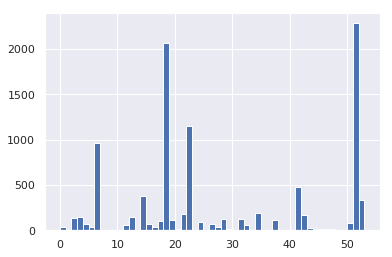

In [118]:
import matplotlib.pyplot as plt

plt.hist(histArray,np.arange(54))